In [1]:
from dotenv import dotenv_values
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
from scipy import stats as st
from tqdm.notebook import tqdm

warnings.filterwarnings("ignore")
import sys
from pathlib import Path

# in jupyter (lab / notebook), based on notebook path
module_path = str(Path.cwd().parents[0] / "src")


if module_path not in sys.path:
    sys.path.append(module_path)
    
from MMAR.MMAR import MMAR

In [2]:
start_date = "2005-01-01"
end_date = "2022-12-31"
df_path = "../data/raw/spy.csv"

In [3]:
config = dotenv_values("../config/.env")

In [4]:
ALPHA_API = config["ALPHA_API"]

In [5]:
def get_df(path: str) -> pd.DataFrame:
    if os.path.isfile(path):
        df = pd.read_csv(path, parse_dates=True, index_col=0)
    else:
        df = yf.download("SPY", start=start_date, end=end_date)
        df.to_csv(path)
    return df

In [6]:
spy = get_df(df_path)

In [7]:
spy = spy[spy.index < "31-12-2017"]

### Simulation using Volume to estimate $\theta$

In [8]:
mmar = MMAR(spy["Close"], volume=spy["Volume"])

In [9]:
S0 = spy.Close.iloc[-2048]
n = 504
simulation = mmar.get_MMAR_MC(S0, n=n, num_sim=1_000_000)

  0%|          | 0/10000 [00:00<?, ?it/s]

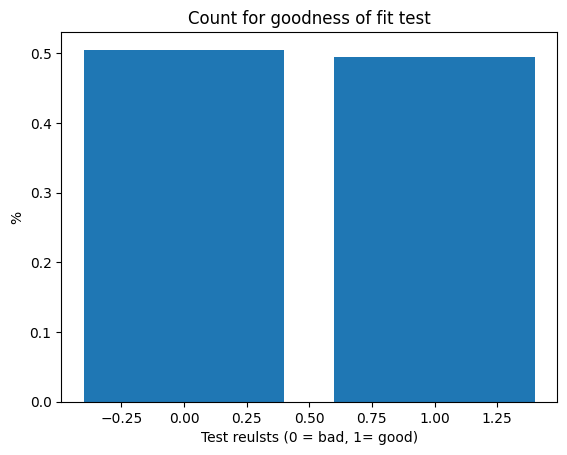

In [21]:
num_samples = min(10_000, len(simulation)*0.1)
selection = np.random.choice(range(len(simulation)),num_samples)
results = []
for idx in tqdm(selection):
    test = st.ks_2samp(np.diff(np.log(spy.iloc[-2048:-2048+n-1]["Close"].values)), np.diff(np.log(simulation[idx,:])))
    results.append(test.pvalue > 0.05)


values, counts = np.unique(results, return_counts=True)
plt.bar(values, counts/len(results))
plt.title("Count for goodness of fit test")
plt.xlabel('Test reulsts (0 = bad, 1= good)')
plt.ylabel('%')

plt.show()

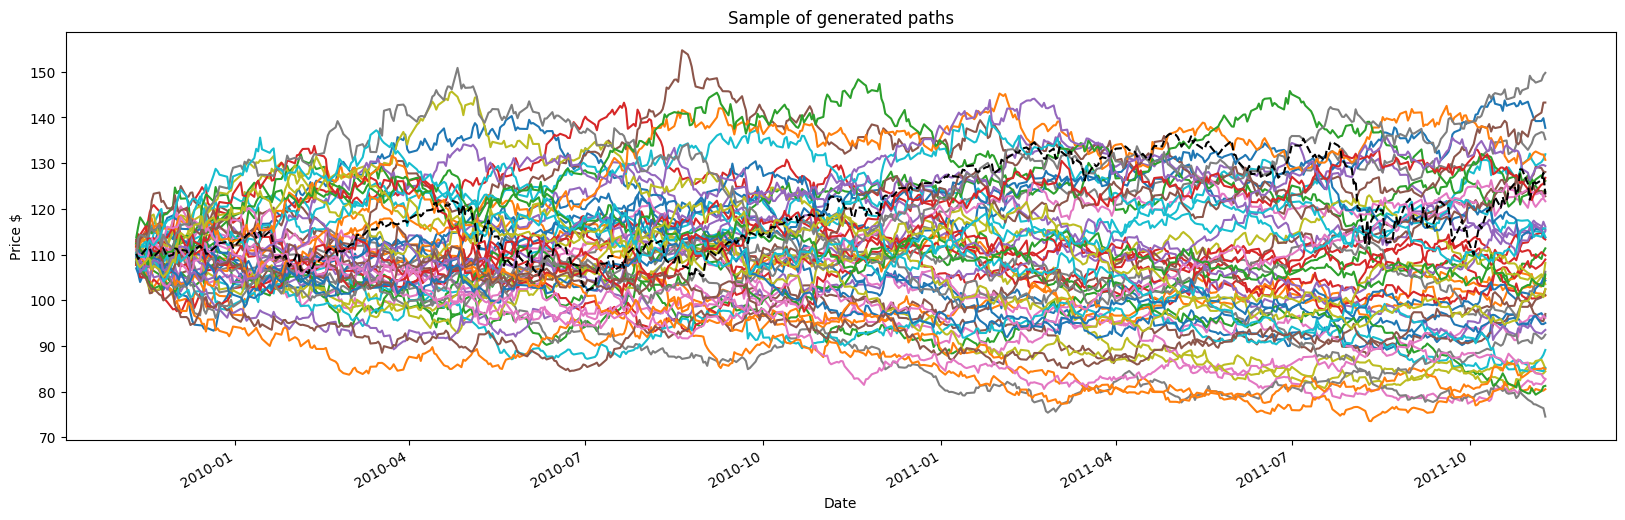

In [20]:
fig, ax = plt.subplots(1,1, figsize=(20,6), sharex=False, sharey=False)

for i in range(50):
    ax.plot(spy.iloc[-2048:-2048+n].index,simulation[i,])
spy.iloc[-2048:-2048+n]["Close"].plot(ax=ax, color = "k", ls="--")
plt.title("Sample of generated paths")
plt.ylabel("Price $")
plt.show()

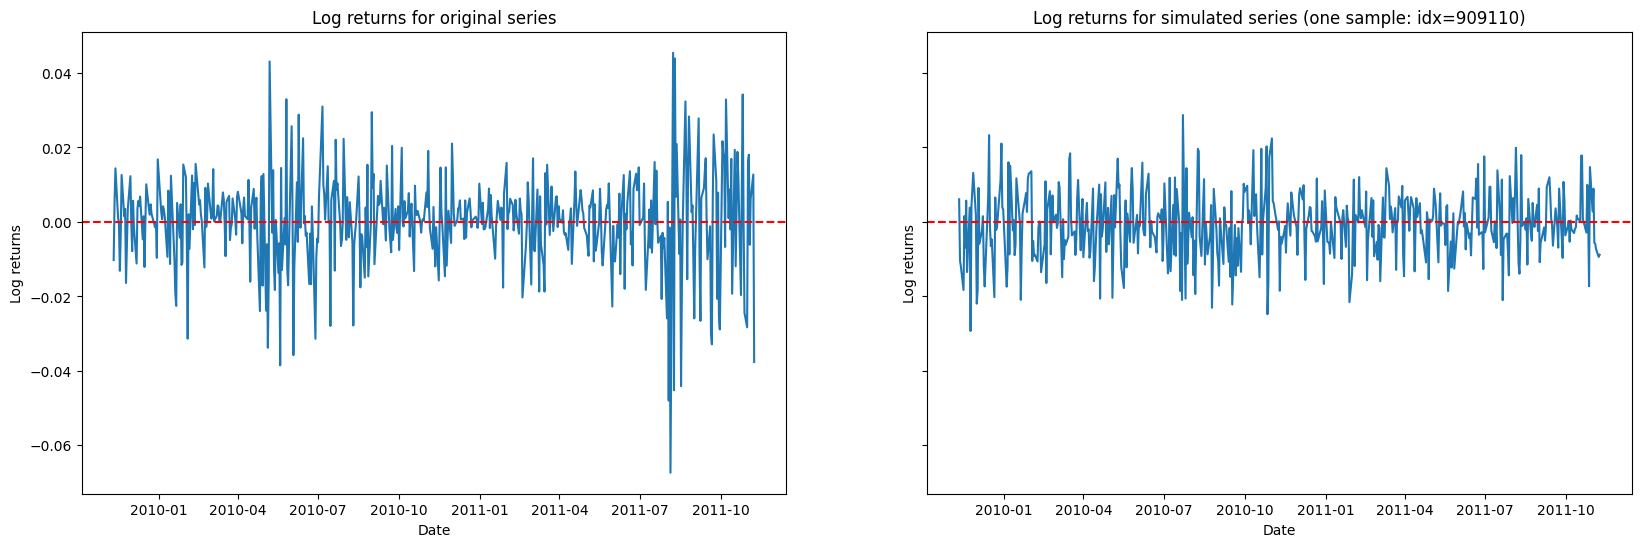

In [12]:
fig, ax = plt.subplots(1,2, figsize=(20,6), sharex=True, sharey=True)
spy_log_diff = np.diff(np.log(spy.iloc[-2048:-2048+n]["Close"]))
ax[0].plot(spy.iloc[-2048:-2048+n-1].index,spy_log_diff)
ax[0].axhline(0.0, c="r", ls="--")
ax[0].set_title("Log returns for original series")
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Log returns")
idx = np.random.choice(range(len(simulation)),1)[0]
ax[1].plot(spy.iloc[-2048:-2048+n-1].index,np.diff(np.log(simulation[idx,])))
ax[1].axhline(0.0, c="r", ls="--")
ax[1].set_title(f"Log returns for simulated series (one sample: {idx=})")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Log returns")

plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]

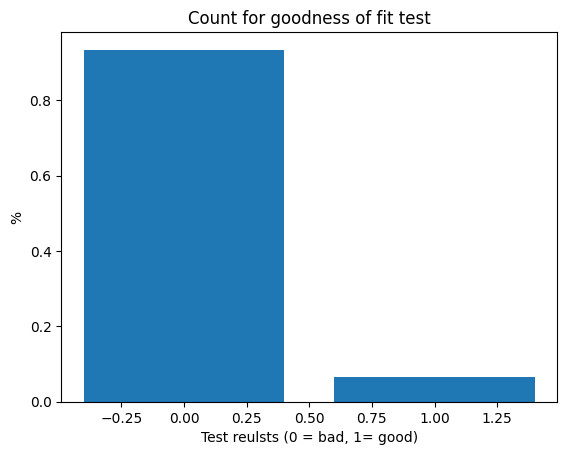

In [24]:
# Comparison using the whole dataset (we expect a worse result)
num_samples = min(10_000, len(simulation)*0.1)
selection = np.random.choice(range(len(simulation)),num_samples)
results = []
for idx in tqdm(selection):
    test = st.ks_2samp(np.diff(np.log(spy["Close"].values)), np.diff(np.log(simulation[idx,:])))
    results.append(test.pvalue > 0.05)


values, counts = np.unique(results, return_counts=True)
plt.bar(values, counts/len(results))
plt.title("Count for goodness of fit test")
plt.xlabel('Test reulsts (0 = bad, 1= good)')
plt.ylabel('%')

plt.show()

### Simulation using random method to estimate $\theta$

In [13]:
mmar2 = MMAR(spy["Close"])

In [14]:
n = 504
S0 = spy.Close.iloc[-2048]
simulation2 = mmar2.get_MMAR_MC(S0, n=n, num_sim=1_000_000)

  0%|          | 0/10000 [00:00<?, ?it/s]

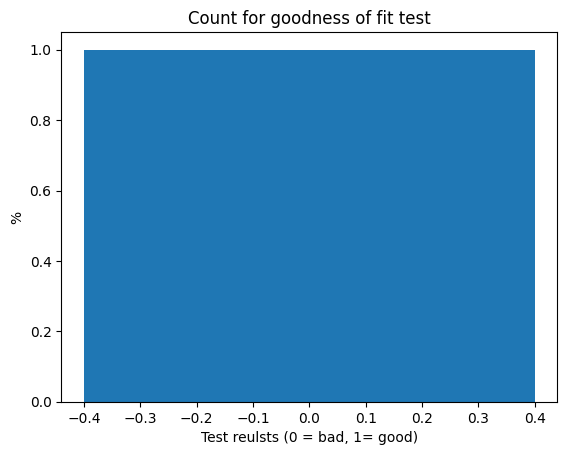

In [18]:
num_samples = min(10_000, len(simulation2)*0.1)
selection2 = np.random.choice(range(len(simulation2)),num_samples)
results2 = []
for idx in tqdm(selection2):
    test = st.ks_2samp(np.diff(np.log(spy.iloc[-2048:-2048+n-1]["Close"].values)), np.diff(np.log(simulation2[idx,:])))
    results2.append(test.pvalue > 0.05)


values2, counts2 = np.unique(results2, return_counts=True)
plt.bar(values2, counts2/len(results2))
plt.title("Count for goodness of fit test")
plt.xlabel('Test reulsts (0 = bad, 1= good)')
plt.ylabel('%')

plt.show()

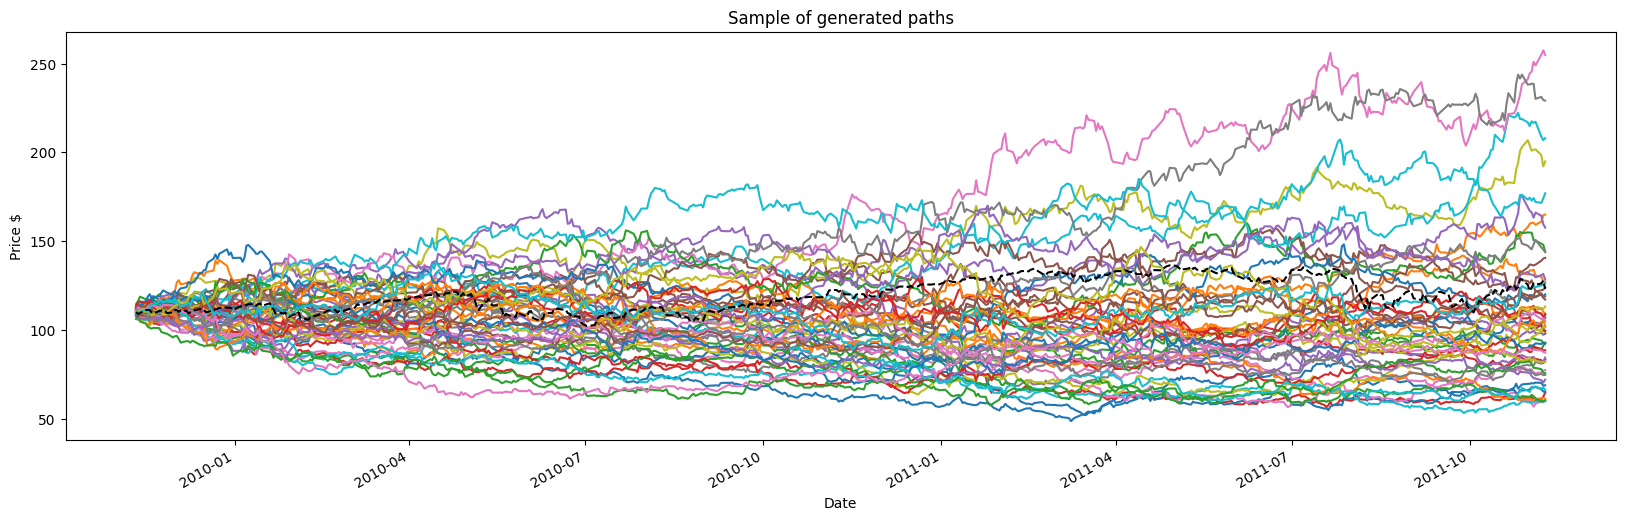

In [22]:
fig, ax = plt.subplots(1,1, figsize=(20,6), sharex=False, sharey=False)

for i in range(50):
    ax.plot(spy.iloc[-2048:-2048+n].index,simulation2[i,])
spy.iloc[-2048:-2048+n]["Close"].plot(ax=ax, color = "k", ls="--")
plt.title("Sample of generated paths")
plt.ylabel("Price $")
plt.show()

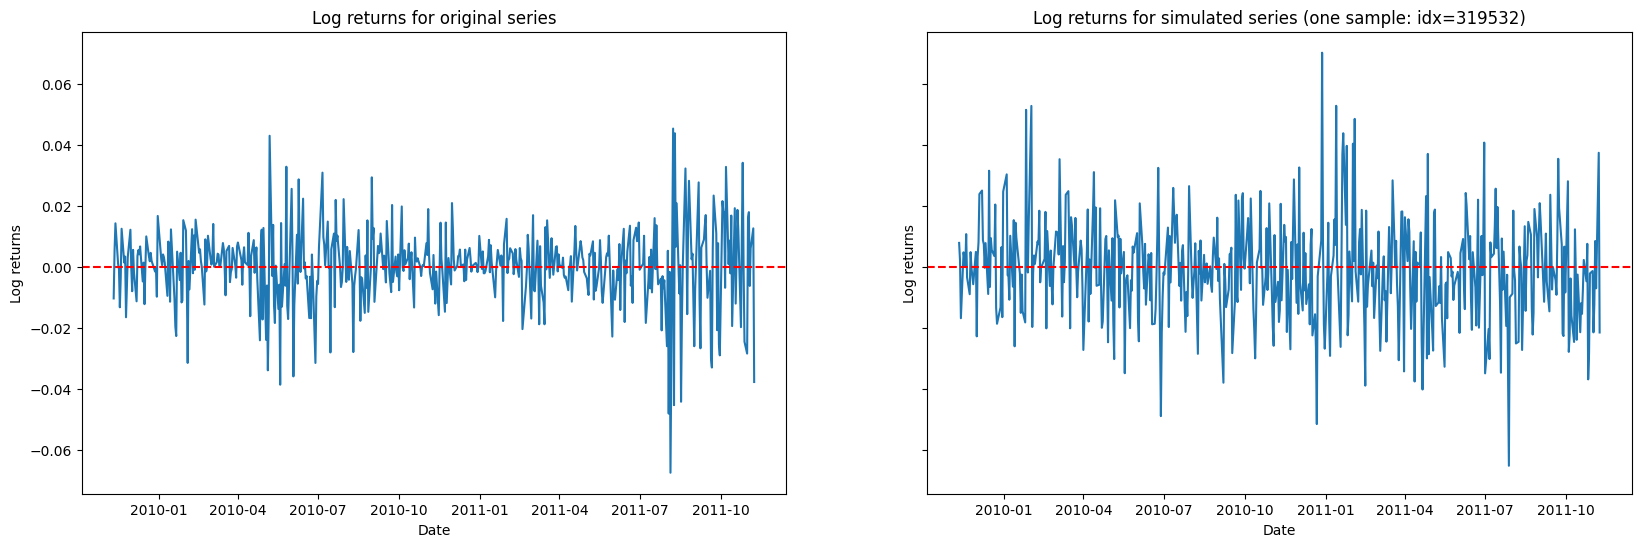

In [17]:
fig, ax = plt.subplots(1,2, figsize=(20,6), sharex=True, sharey=True)
spy_log_diff = np.diff(np.log(spy.iloc[-2048:-2048+n]["Close"]))
ax[0].plot(spy.iloc[-2048:-2048+n-1].index,spy_log_diff)
ax[0].axhline(0.0, c="r", ls="--")
ax[0].set_title("Log returns for original series")
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Log returns")
idx = np.random.choice(range(len(simulation)),1)[0]
ax[1].plot(spy.iloc[-2048:-2048+n-1].index,np.diff(np.log(simulation2[idx,])))
ax[1].axhline(0.0, c="r", ls="--")
ax[1].set_title(f"Log returns for simulated series (one sample: {idx=})")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Log returns")

plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]

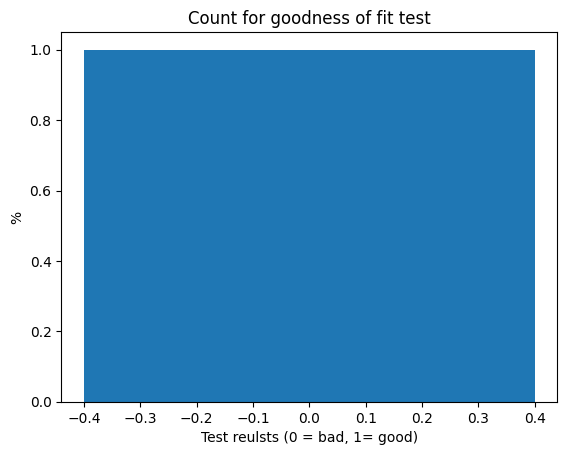

In [25]:
# Make comparison using the whole original dataset (we expect better outcomes)
num_samples = min(10_000, len(simulation2)*0.1)
selection2 = np.random.choice(range(len(simulation2)),num_samples)
results2 = []
for idx in tqdm(selection2):
    test = st.ks_2samp(np.diff(np.log(spy["Close"].values)), np.diff(np.log(simulation2[idx,:])))
    results2.append(test.pvalue > 0.05)


values2, counts2 = np.unique(results2, return_counts=True)
plt.bar(values2, counts2/len(results2))
plt.title("Count for goodness of fit test")
plt.xlabel('Test reulsts (0 = bad, 1= good)')
plt.ylabel('%')

plt.show()

### Same approach, but with different seed

In [26]:
mmar2 = MMAR(spy["Close"], 21)

In [27]:
n = 504
S0 = spy.Close.iloc[-2048]
simulation2 = mmar2.get_MMAR_MC(S0, n=n, num_sim=1_000_000)

  0%|          | 0/10000 [00:00<?, ?it/s]

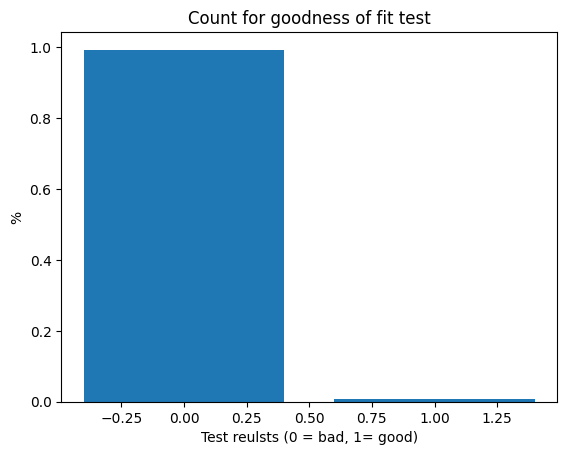

In [28]:
num_samples = min(10_000, len(simulation2)*0.1)
selection2 = np.random.choice(range(len(simulation2)),num_samples)
results2 = []
for idx in tqdm(selection2):
    test = st.ks_2samp(np.diff(np.log(spy.iloc[-2048:-2048+n-1]["Close"].values)), np.diff(np.log(simulation2[idx,:])))
    results2.append(test.pvalue > 0.05)


values2, counts2 = np.unique(results2, return_counts=True)
plt.bar(values2, counts2/len(results2))
plt.title("Count for goodness of fit test")
plt.xlabel('Test reulsts (0 = bad, 1= good)')
plt.ylabel('%')

plt.show()

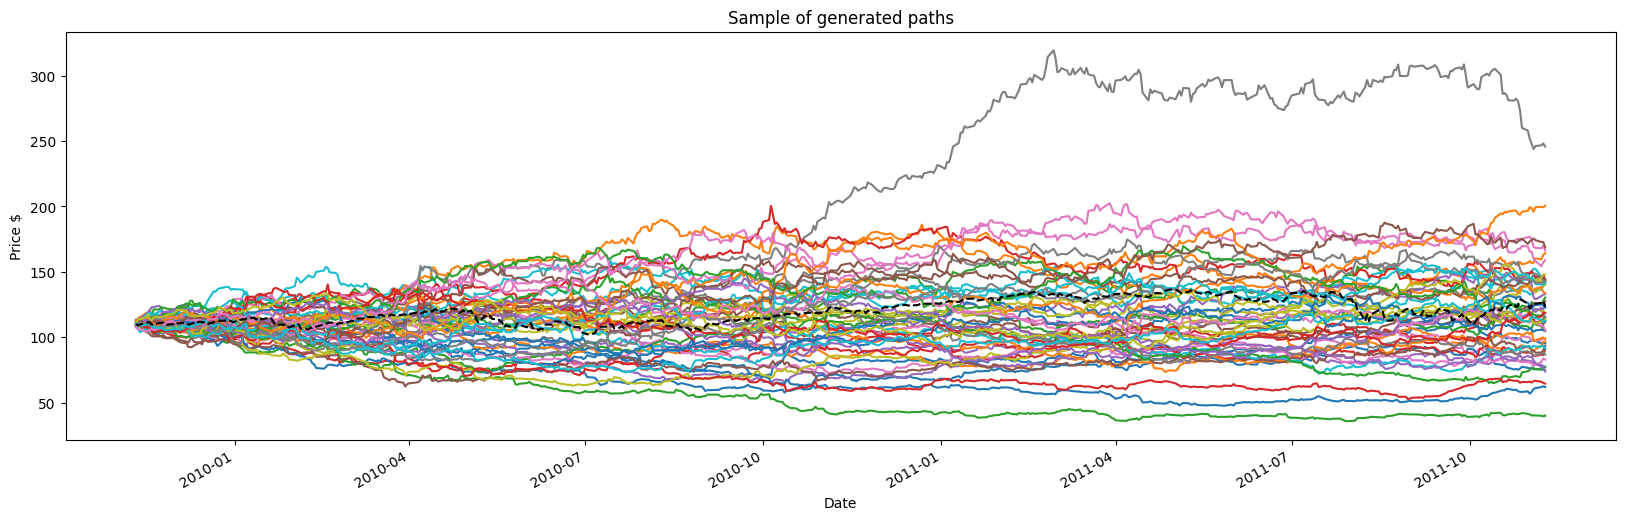

In [30]:
fig, ax = plt.subplots(1,1, figsize=(20,6), sharex=False, sharey=False)

for i in range(50):
    ax.plot(spy.iloc[-2048:-2048+n].index,simulation2[i,])
spy.iloc[-2048:-2048+n]["Close"].plot(ax=ax, color = "k", ls="--")
plt.title("Sample of generated paths")
plt.ylabel("Price $")
plt.show()

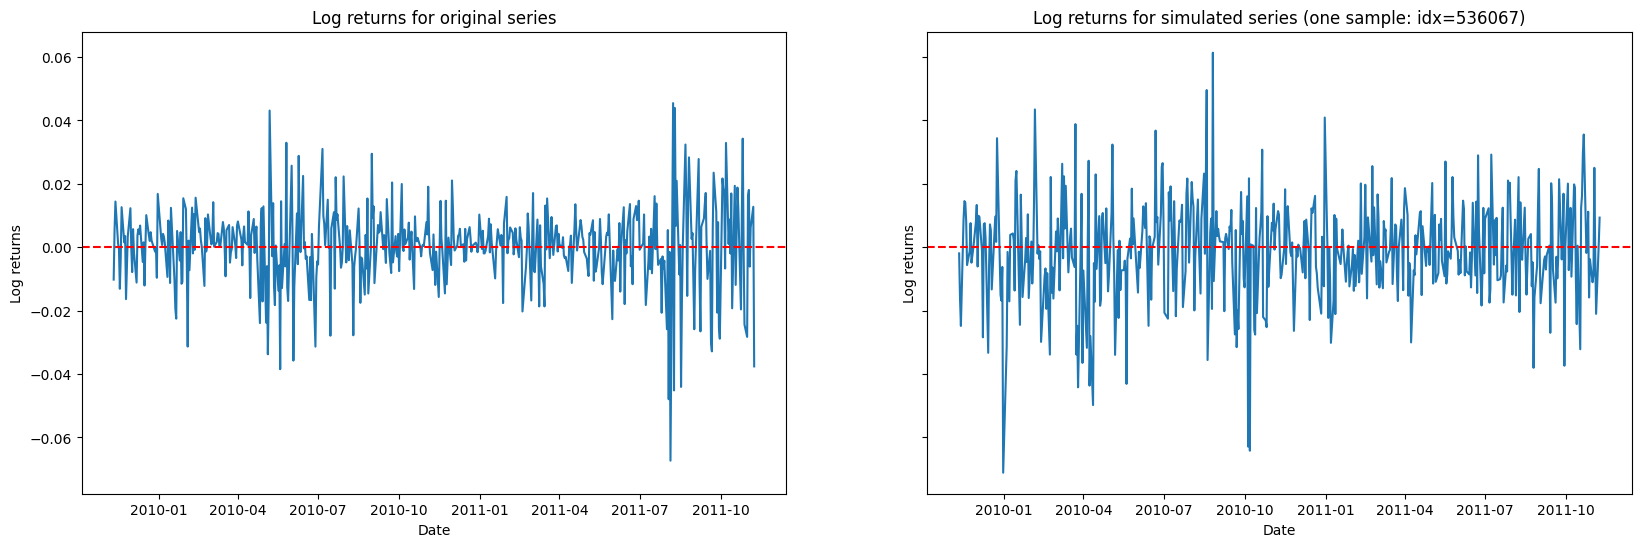

In [31]:
fig, ax = plt.subplots(1,2, figsize=(20,6), sharex=True, sharey=True)
spy_log_diff = np.diff(np.log(spy.iloc[-2048:-2048+n]["Close"]))
ax[0].plot(spy.iloc[-2048:-2048+n-1].index,spy_log_diff)
ax[0].axhline(0.0, c="r", ls="--")
ax[0].set_title("Log returns for original series")
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Log returns")
idx = np.random.choice(range(len(simulation)),1)[0]
ax[1].plot(spy.iloc[-2048:-2048+n-1].index,np.diff(np.log(simulation2[idx,])))
ax[1].axhline(0.0, c="r", ls="--")
ax[1].set_title(f"Log returns for simulated series (one sample: {idx=})")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Log returns")

plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]

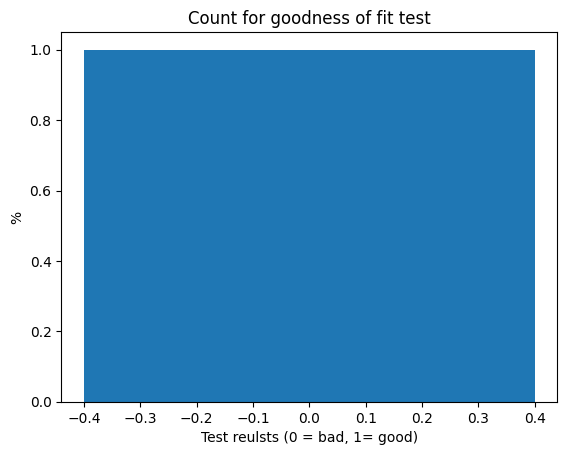

In [32]:
# Make comparison using the whole original dataset (we expect better outcomes)
num_samples = min(10_000, len(simulation2)*0.1)
selection2 = np.random.choice(range(len(simulation2)),num_samples)
results2 = []
for idx in tqdm(selection2):
    test = st.ks_2samp(np.diff(np.log(spy["Close"].values)), np.diff(np.log(simulation2[idx,:])))
    results2.append(test.pvalue > 0.05)


values2, counts2 = np.unique(results2, return_counts=True)
plt.bar(values2, counts2/len(results2))
plt.title("Count for goodness of fit test")
plt.xlabel('Test reulsts (0 = bad, 1= good)')
plt.ylabel('%')

plt.show()

The comparison shows that using the Volume approach gives better results than a pure random method which is higly influenced by the inital seed (something over which we have no control). Since we use only a fraction of the Volumes, the results are better when comparing them with a similar slice of the time series.